In [1]:
#!/usr/bin/env python
# coding: utf-8

import sys
# load standard python modules

import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib.backends.backend_pdf import PdfPages

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# load custom modules required for jetCLR training
from modules.jet_augs import remove_jet_and_rescale_pT
from modules.transformer import Transformer
from modules.losses import contrastive_loss, align_loss, uniform_loss, contrastive_loss_num_den
from modules.perf_eval import get_perf_stats, linear_classifier_test, plot_losses
from modules.neural_net import create_and_run_nn


seed = 1
#torch.manual_seed(seed)
#random.seed(seed)
#np.random.seed(seed)
#torch.cuda.empty_cache()


#from numba import cuda 
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
#device = cuda.get_current_device()
#device.reset()

torch.set_num_threads(2)

# set gpu device
#device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
device = torch.device( "cpu")
print( "device: " + str( device ), flush=True)




device: cpu


# Load in the data + crop

In [2]:
path_to_save_dir = "/global/home/users/rrmastandrea/training_data_vf/"

sig_samp_id = "nCWoLa_sig_85000_nCWoLa_bkg_0_n_nonzero_50_n_pad_0_n_jet_2/"
bkg_samp_id = "nCWoLa_sig_0_nCWoLa_bkg_85000_n_nonzero_50_n_pad_0_n_jet_2/"

TEST_dir = "STANDARD_TEST_SET_n_sig_10k_n_bkg_10k_n_nonzero_50_n_pad_0_n_jet_2/"

n_constits_max = 50
n_jets = 2

path_to_sig_data = path_to_save_dir+sig_samp_id
print(path_to_sig_data)
path_to_bkg_data = path_to_save_dir+bkg_samp_id
print(path_to_bkg_data)

path_to_STS = path_to_save_dir+TEST_dir
print(path_to_STS)


sig_data = np.load(path_to_sig_data+"data_train.npy")
sig_labels = np.load(path_to_sig_data+"labels_train.npy")
bkg_data = np.load(path_to_bkg_data+"data_train.npy")
bkg_labels = np.load(path_to_bkg_data+"labels_train.npy")


STS_data = np.load(path_to_STS+"data.npy")
STS_labels = np.load(path_to_STS+"labels.npy")


# Crop the data, rescale pt
cropped_sig_data = remove_jet_and_rescale_pT(sig_data, n_jets)
cropped_bkg_data = remove_jet_and_rescale_pT(bkg_data, n_jets)
sig_labels = sig_labels
bkg_labels = bkg_labels

cropped_STS_data = remove_jet_and_rescale_pT(STS_data, n_jets)

# print data dimensions
print( "Sig data shape: " + str( cropped_sig_data.shape ), flush=True)
print( "Sig labels shape: " + str( sig_labels.shape ), flush=True)
print( "Bkg data shape: " + str( cropped_bkg_data.shape ), flush=True)
print( "Sig data shape: " + str( bkg_labels.shape ), flush=True)


print( "STS data shape: " + str( cropped_STS_data.shape ), flush=True)
print( "STS labels shape: " + str( STS_labels.shape ), flush=True)

num_consts_tot = 100

cropped_STS_data = np.reshape(cropped_STS_data,(cropped_STS_data.shape[0],3*num_consts_tot))


/global/home/users/rrmastandrea/training_data_vf/nCWoLa_sig_85000_nCWoLa_bkg_0_n_nonzero_50_n_pad_0_n_jet_2/
/global/home/users/rrmastandrea/training_data_vf/nCWoLa_sig_0_nCWoLa_bkg_85000_n_nonzero_50_n_pad_0_n_jet_2/
/global/home/users/rrmastandrea/training_data_vf/STANDARD_TEST_SET_n_sig_10k_n_bkg_10k_n_nonzero_50_n_pad_0_n_jet_2/
Sig data shape: (85000, 3, 100)
Sig labels shape: (85000,)
Bkg data shape: (85000, 3, 100)
Sig data shape: (85000,)
STS data shape: (20000, 3, 100)
STS labels shape: (20000,)


In [11]:
# For the actual anomaly detection, we need to split the datasets in half
# i.e. the first "mixed" sample is the first half of the background events
# the second mixed sample is a blend of the second half of the background events

cropped_sig_data = remove_jet_and_rescale_pT(sig_data, n_jets)
cropped_bkg_data = remove_jet_and_rescale_pT(bkg_data, n_jets)

first_half_sig_data = cropped_sig_data[:42500]
second_half_sig_data = cropped_sig_data[42500:]


first_half_bkg_data = cropped_bkg_data[:42500]
second_half_bkg_data = cropped_bkg_data[42500:]


(42500, 3, 100)
(42500, 3, 100)
(42500, 3, 100)
(42500, 3, 100)


# Functions to generate mixed samples, then train-val-test splits

In [21]:
# Make mixed samples

def generate_mixed_sample(sig_set, bkg_set, f):
    
    """
    INPUTS
    f: signal fraction for sample 1
        -- by default, the signal fraction for sample 2 is 1 - f
    
    OUTPUTS
    M1_reps, M2_reps : shuffled array of [signal + background] samples
    """
    ((sig_M1, sig_M2),
     (bkg_M2, bkg_M1),) = [train_test_split(arr, test_size=(1-f)) for arr in [
                                                sig_set,
                                                bkg_set,]] 

    # concatenate the signal, background
    M1_reps = np.concatenate((sig_M1, bkg_M1))
    M2_reps = np.concatenate((sig_M2, bkg_M2))
    
    # shuffle
    M1_reps = shuffle(M1_reps)
    M2_reps = shuffle(M2_reps)
    
    return M1_reps, M2_reps

# Make the test - val - train splits

def generate_train_test_val(M1, M2, test_size = 0.0, val_size = 0.3):
    """
    INPUTS
    M1: np.array of data to be given the label 1
    M2: np.array of data to be given the label 0
    
    OUPUTS
    training, validation, and testing datasets + labels
    
    """
    """
    # split data into train-test
    ((M1_train, M1_test),
     (M2_train, M2_test),) = [train_test_split(arr, test_size=test_size) for arr in [
                                                M1,
                                               M2,]]

    """
    # split train data into train-val
    ((M1_train, M1_val),
     (M2_train, M2_val),) = [train_test_split(arr, test_size=val_size) for arr in [
                                                M1,
                                                M2,]]

    # prepare the datasets + labels
    data_train = np.concatenate((M1_train, M2_train))
    labels_train = np.concatenate([np.ones(M1_train.shape[0]),np.zeros(M2_train.shape[0])])
    data_train, labels_train = shuffle(data_train, labels_train)

    data_val = np.concatenate((M1_val, M2_val))
    labels_val = np.concatenate([np.ones(M1_val.shape[0]),np.zeros(M2_val.shape[0])])
    data_val, labels_val = shuffle(data_val, labels_val)
    
    """
    data_test = np.concatenate((M1_test, M2_test))
    labels_test = np.concatenate([np.ones(M1_test.shape[0]),np.zeros(M2_test.shape[0])])
    data_test, labels_test = shuffle(data_test, labels_test)
    """
    
    return data_train, labels_train, data_val, labels_val

    

# Testing the classifier (fully supervised)

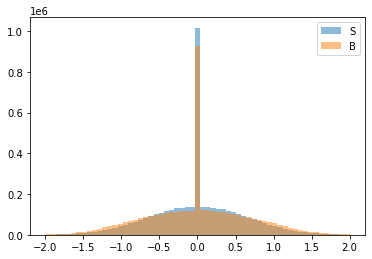

In [14]:
# Make the datasets


layer = 1
  
M1 = first_half_sig_data
M2 = first_half_bkg_data
bins = np.linspace(-2,2,60)

    
S = np.reshape(M1[:,layer,:], (M1.shape[0]*M1.shape[2],1))
B = np.reshape(M2[:,layer,:], (M2.shape[0]*M2.shape[2],1))


plt.figure()
plt.hist(S, bins, label = "S", alpha = 0.5)
plt.hist(B, bins, label = "B", alpha = 0.5)
plt.legend()
plt.show()

Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)
Starting training...


 27%|██▋       | 270/1000 [01:41<04:33,  2.67it/s]


INFO: Early stopping
Finished Training


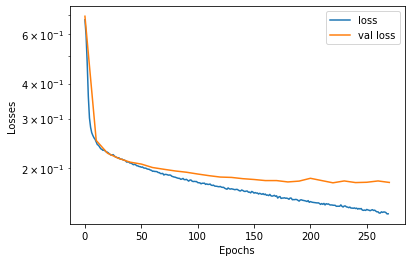

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide


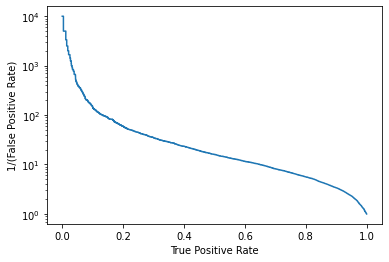

Accuracy of the network: 70 %
ROC AUC: 0.882662095


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


In [15]:
data_train, labels_train, data_val, labels_val = generate_train_test_val(M1, M2)

# Define the NN parameters

full_sup_AUC = 0
full_sup_maxsic = 0
fixed_TPR = 0.5
full_sup_FPRatTPR = 0

data_train = np.reshape(data_train,(data_train.shape[0],3*num_consts_tot))
data_val = np.reshape(data_val,(data_val.shape[0],3*num_consts_tot))

# print data dimensions
print( "Train data shape: " + str( data_train.shape ), flush=True)
print( "Train labels shape: " + str( labels_train.shape ), flush=True)
print( "Val data shape: " + str( data_val.shape ), flush=True)
print( "Val labels shape: " + str( labels_val.shape ), flush=True)

input_shape = 3*num_consts_tot   
num_epochs = 1000
batch_size = 500
update_epochs = 10
lr = 0.0001

# Run the NN

performance_stats = create_and_run_nn(device, input_shape, num_epochs, batch_size, update_epochs, lr, 
                              data_train, labels_train, 
                              data_val, labels_val,
                              cropped_STS_data, STS_labels, 
                              verbose = True, early_stop = True, LRschedule = False)

# Plot the output losses   
plt.figure()
plt.plot(performance_stats["epochs"],performance_stats["losses"], label = "loss")
plt.plot(performance_stats["val_epochs"],performance_stats["val_losses"], label = "val loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.yscale("log")
plt.legend()
plt.show()

plt.figure()
plt.plot(performance_stats["tpr"], 1.0/performance_stats["fpr"])
plt.yscale("log")
plt.xlabel("True Positive Rate")
plt.ylabel("1/(False Positive Rate)")
plt.show()

print("Accuracy of the network: %d %%" % (100.00 *performance_stats["acc"]))
print("ROC AUC:", performance_stats["auc"])

full_sup_AUC = performance_stats["auc"]

SIC = performance_stats["tpr"]/np.sqrt(performance_stats["fpr"])
finite_SIC = SIC[np.isfinite(SIC)]
full_sup_maxsic = np.max(finite_SIC)

dist_from_fixed_tpr = np.abs(performance_stats["tpr"] - fixed_TPR)
min_dist_ind = np.where(dist_from_fixed_tpr == np.min(dist_from_fixed_tpr))[0][0]
full_sup_FPRatTPR = np.sqrt(performance_stats["fpr"][min_dist_ind])

    
    


# Testing the classifier (CWoLa)

Starting CWoLa training run with f1 = 0
Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


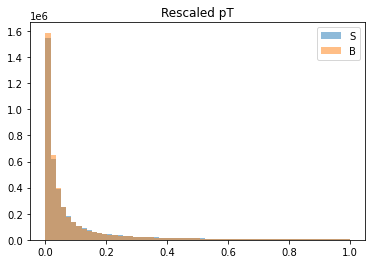

Starting training...


  6%|▌         | 60/1000 [00:22<05:53,  2.66it/s]


INFO: Early stopping
Finished Training


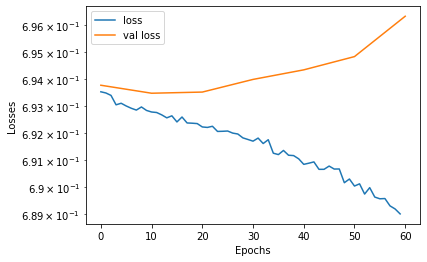

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide


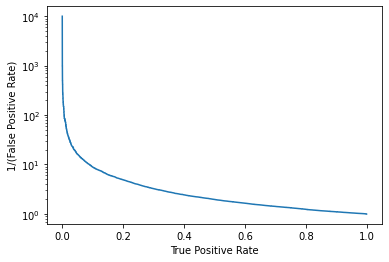

Accuracy of the network: 49 %
ROC AUC: 0.49256933500000005

Starting CWoLa training run with f1 = 0.0001
(4, 3, 100)
(42496, 3, 100)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide


Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


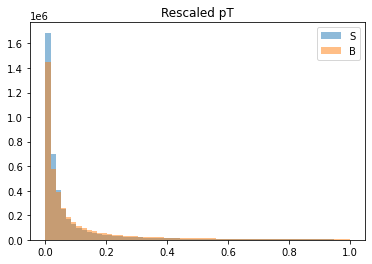

Starting training...


  6%|▌         | 60/1000 [00:22<05:53,  2.66it/s]


INFO: Early stopping
Finished Training


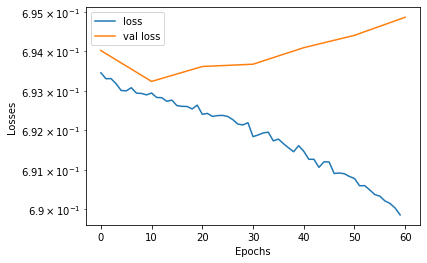

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide


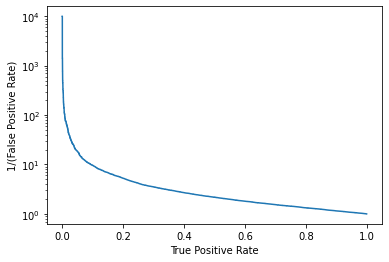

Accuracy of the network: 52 %
ROC AUC: 0.5275362

Starting CWoLa training run with f1 = 0.001
(42, 3, 100)
(42458, 3, 100)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide


Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


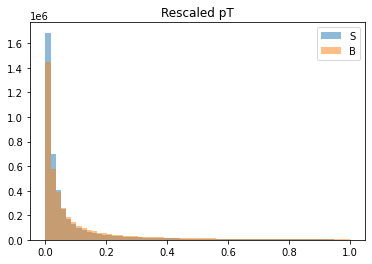

Starting training...


  7%|▋         | 70/1000 [00:26<05:49,  2.66it/s]


INFO: Early stopping
Finished Training


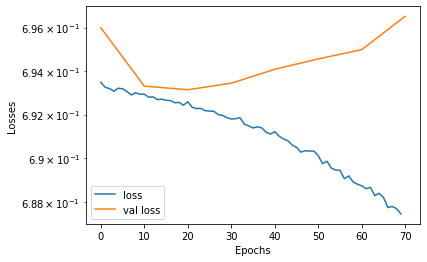

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide


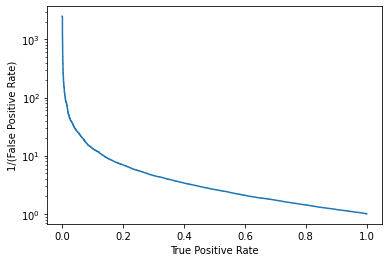

Accuracy of the network: 55 %
ROC AUC: 0.58021166

Starting CWoLa training run with f1 = 0.01
(425, 3, 100)
(42075, 3, 100)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide


Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


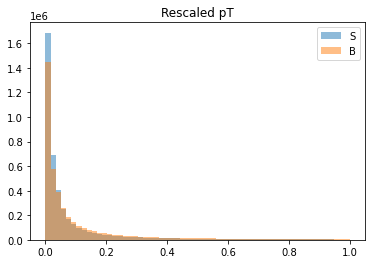

Starting training...


  6%|▌         | 60/1000 [00:22<05:51,  2.67it/s]


INFO: Early stopping
Finished Training


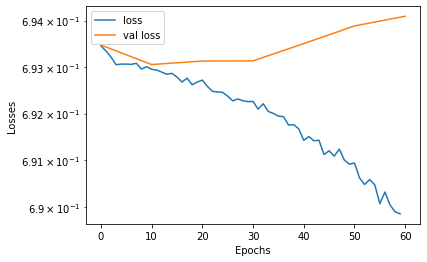

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide


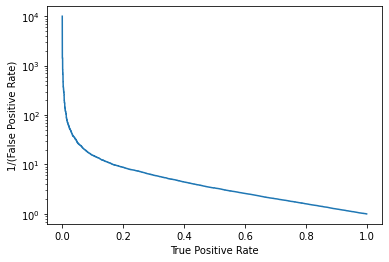

Accuracy of the network: 60 %
ROC AUC: 0.6353902549999999

Starting CWoLa training run with f1 = 0.1
(4250, 3, 100)
(38250, 3, 100)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide


Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


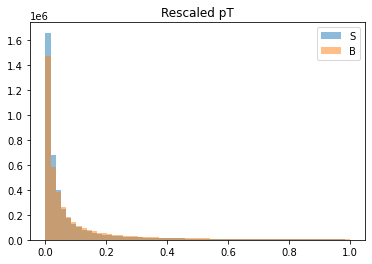

Starting training...


 10%|█         | 100/1000 [00:37<05:39,  2.65it/s]


INFO: Early stopping
Finished Training


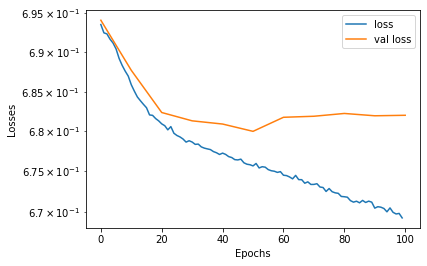

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide


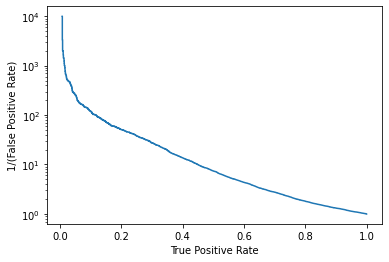

Accuracy of the network: 68 %
ROC AUC: 0.7334729799999999

Starting CWoLa training run with f1 = 0.2
(8500, 3, 100)
(34000, 3, 100)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide


Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


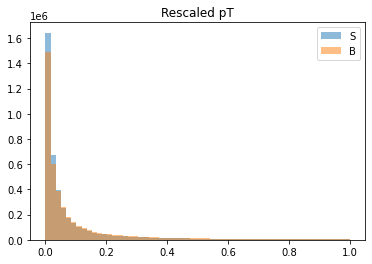

Starting training...


  9%|▉         | 90/1000 [00:34<05:45,  2.64it/s]


INFO: Early stopping
Finished Training


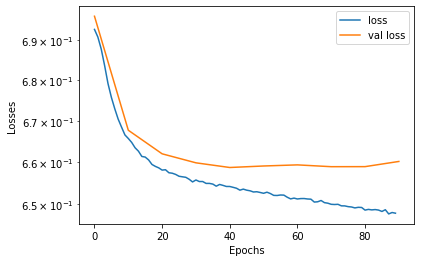

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide


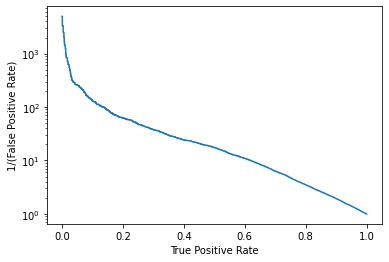

Accuracy of the network: 77 %
ROC AUC: 0.8355920300000002

Starting CWoLa training run with f1 = 0.3
(12750, 3, 100)
(29750, 3, 100)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide


Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


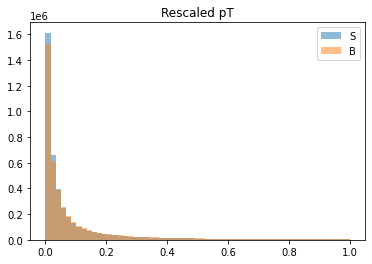

Starting training...


 16%|█▌        | 160/1000 [00:59<05:14,  2.67it/s]


INFO: Early stopping
Finished Training


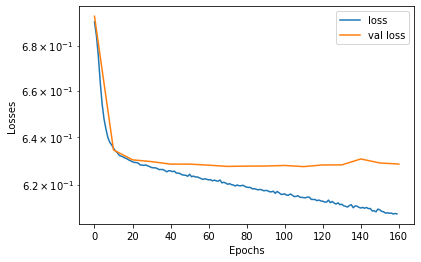

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide


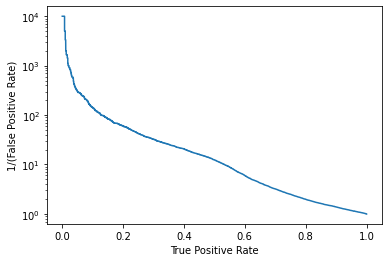

Accuracy of the network: 69 %
ROC AUC: 0.763003345

Starting CWoLa training run with f1 = 0.4
(17000, 3, 100)
(25500, 3, 100)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide


Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


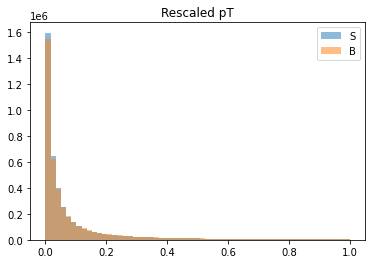

Starting training...


 19%|█▉        | 190/1000 [01:10<05:01,  2.69it/s]


INFO: Early stopping
Finished Training


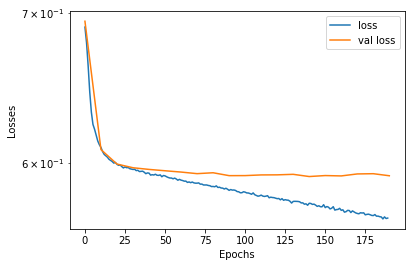

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide


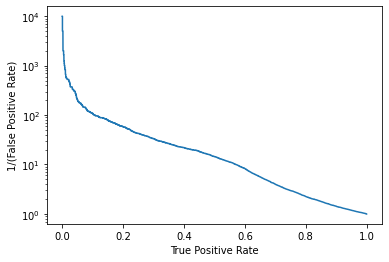

Accuracy of the network: 72 %
ROC AUC: 0.7844489800000001

Starting CWoLa training run with f1 = 0.6
(25500, 3, 100)
(17000, 3, 100)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide


Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


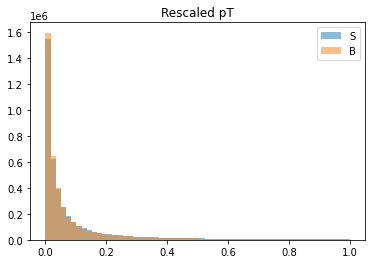

Starting training...


 20%|██        | 200/1000 [01:15<05:01,  2.65it/s]


INFO: Early stopping
Finished Training


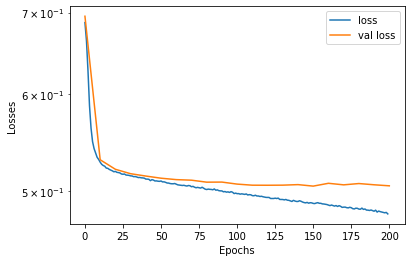

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide


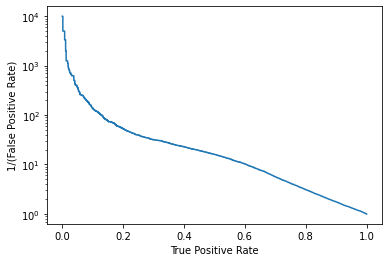

Accuracy of the network: 70 %
ROC AUC: 0.82191051

Starting CWoLa training run with f1 = 1


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide


Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


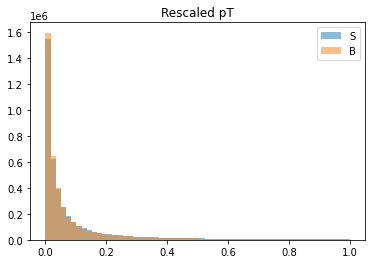

Starting training...


 35%|███▌      | 350/1000 [02:11<04:03,  2.66it/s]


INFO: Early stopping
Finished Training


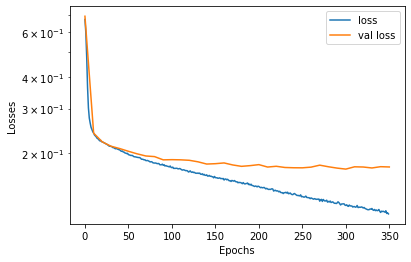

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide


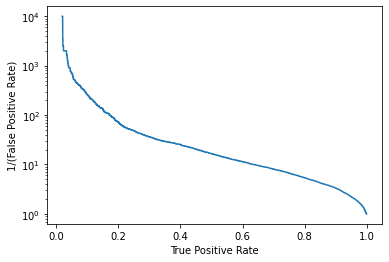

Accuracy of the network: 68 %
ROC AUC: 0.88262891



/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide


In [25]:
# Define the NN parameters

input_shape = 3*num_consts_tot
num_epochs = 1000
batch_size = 500
update_epochs = 10
lr = 0.0001

visualize = True

f1_vals = []
ROC_AUC_vals = []
maxsic_vals = []
FPRatTPR_vals = []

f1_to_probe = [0, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 1]

for f1 in f1_to_probe:
    
    print("Starting CWoLa training run with f1 =", f1)
    f1_vals.append(f1)
    
    
    
    
    if f1 == 0: # weird bug unless this is manually dne
        data_train, labels_train, data_val, labels_val = generate_train_test_val(second_half_bkg_data, first_half_bkg_data)
    elif f1 == 1:
        data_train, labels_train, data_val, labels_val = generate_train_test_val(second_half_sig_data, first_half_bkg_data)
    else:
        # make the datasets / mixed samples
        # We only want to keep M1 here, as that's the set with a fraction f of the anomaly 
        M1, M2 = generate_mixed_sample(second_half_sig_data, second_half_bkg_data, f1)
    
        # The other "mixed" sample is background only
        data_train, labels_train, data_val, labels_val = generate_train_test_val(M1, first_half_bkg_data)
        
    data_train = np.reshape(data_train,(data_train.shape[0],3*num_consts_tot))
    data_val = np.reshape(data_val,(data_val.shape[0],3*num_consts_tot))

    # print data dimensions
    print( "Train data shape: " + str( data_train.shape ), flush=True)
    print( "Train labels shape: " + str( labels_train.shape ), flush=True)
    print( "Val data shape: " + str( data_val.shape ), flush=True)
    print( "Val labels shape: " + str( labels_val.shape ), flush=True)

    # Run the NN

    # visualise the mixed samples

    if visualize:

        S = np.reshape(M1[:,0,:], (M1.shape[0]*M1.shape[2],1))
        B = np.reshape(M2[:,0,:], (M2.shape[0]*M2.shape[2],1))

        bins = np.linspace(0,1,60)
        plt.figure()
        plt.hist(S, bins, label = "S", alpha = 0.5)
        plt.hist(B, bins, label = "B", alpha = 0.5)
        plt.legend()
        plt.title("Rescaled pT")
        plt.show()

    performance_stats = create_and_run_nn(device, input_shape, num_epochs, batch_size, update_epochs, lr, 
                          data_train, labels_train, 
                          data_val, labels_val,
                          cropped_STS_data, STS_labels, 
                          verbose = True, early_stop = True, LRschedule = False)

    if visualize:
        # Plot the output losses   
        plt.figure()
        plt.plot(performance_stats["epochs"],performance_stats["losses"], label = "loss")
        plt.plot(performance_stats["val_epochs"],performance_stats["val_losses"], label = "val loss")
        plt.xlabel("Epochs")
        plt.ylabel("Losses")
        plt.yscale("log")
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(performance_stats["tpr"], 1.0/performance_stats["fpr"])
        plt.yscale("log")
        plt.xlabel("True Positive Rate")
        plt.ylabel("1/(False Positive Rate)")
        plt.show()

    print("Accuracy of the network: %d %%" % (100.00 *performance_stats["acc"]))
    print("ROC AUC:", performance_stats["auc"])

    ROC_AUC_vals.append(performance_stats["auc"])
    
    SIC = performance_stats["tpr"]/np.sqrt(performance_stats["fpr"])
    finite_SIC = SIC[np.isfinite(SIC)]
    maxsic_vals.append(np.max(finite_SIC))

    dist_from_fixed_tpr = np.abs(performance_stats["tpr"] - fixed_TPR)
    min_dist_ind = np.where(dist_from_fixed_tpr == np.min(dist_from_fixed_tpr))[0][0]
    FPRatTPR_vals.append(np.sqrt(performance_stats["fpr"][min_dist_ind]))
    
    print()




In [26]:
cwola_npy_save_dict = "CWoLa_results_npy/const_rep/"

# save the f1 vals scanned over
np.save(cwola_npy_save_dict+"f1_vals_seed"+str(seed), f1_vals)

    
# save the full sup 
np.save(cwola_npy_save_dict+"full_sup_AUC"+"_seed"+str(seed), np.full(len(f1_vals), full_sup_AUC))
np.save(cwola_npy_save_dict+"full_sup_maxsic"+"_seed"+str(seed), np.full(len(f1_vals), full_sup_maxsic))
np.save(cwola_npy_save_dict+"full_sup_FPRatTPR"+"_seed"+str(seed), np.full(len(f1_vals), full_sup_FPRatTPR))

# save the Cwola
np.save(cwola_npy_save_dict+"CWoLa_AUC_layer"+"_seed"+str(seed), [max(x, 1.0-x) for x in ROC_AUC_vals])
np.save(cwola_npy_save_dict+"CWoLa_sup_maxsic"+"_seed"+str(seed), maxsic_vals)
np.save(cwola_npy_save_dict+"CWoLa_sup_FPRatTPR"+"_seed"+str(seed), FPRatTPR_vals)



In [28]:
cwola_npy_save_dict = "CWoLa_results_npy/const_rep/"

seeds = [1]


full_sup_results_dict = {seed:{"AUC":0,
                        "maxsic":0,
                        "FPRatTPR":0,} for seed in seeds}

cwola_results_dict = {seed:{"AUC":0,
                        "maxsic":0,
                        "FPRatTPR":0,} for seed in seeds}

for seed in seeds:

    full_sup_results_dict[seed]["AUC"] = np.load(cwola_npy_save_dict+"full_sup_AUC"+"_seed"+str(seed)+".npy")
    full_sup_results_dict[seed]["maxsic"] = np.load(cwola_npy_save_dict+"full_sup_maxsic"+"_seed"+str(seed)+".npy")
    full_sup_results_dict[seed]["FPRatTPR"] = np.load(cwola_npy_save_dict+"full_sup_FPRatTPR"+"_seed"+str(seed)+".npy")

    cwola_results_dict[seed]["AUC"] = np.load(cwola_npy_save_dict+"CWoLa_AUC_layer"+"_seed"+str(seed)+".npy")
    cwola_results_dict[seed]["maxsic"] = np.load(cwola_npy_save_dict+"CWoLa_sup_maxsic"+"_seed"+str(seed)+".npy")
    cwola_results_dict[seed]["FPRatTPR"] = np.load(cwola_npy_save_dict+"CWoLa_sup_FPRatTPR"+"_seed"+str(seed)+".npy")
    
f1_vals = np.load(cwola_npy_save_dict+"f1_vals_seed"+str(1)+".npy")



# for eahc f1 val, calculate the mean and std from the seeds
avg_full_sup_results_dict = {"AUC":[[],[]],  # vals, errors
                        "maxsic":[[],[]],
                        "FPRatTPR":[[],[]],}
avg_cwola_results_dict = {"AUC":[[],[]],
                        "maxsic":[[],[]],
                        "FPRatTPR":[[],[]],}


for i in range(len(f1_vals)):
    avg_full_sup_results_dict["AUC"][0].append(np.mean([full_sup_results_dict[seed]["AUC"][i] for seed in seeds]))
    avg_full_sup_results_dict["AUC"][1].append(np.std([full_sup_results_dict[seed]["AUC"][i] for seed in seeds]))
    avg_full_sup_results_dict["maxsic"][0].append(np.mean([full_sup_results_dict[seed]["maxsic"][i] for seed in seeds]))
    avg_full_sup_results_dict["maxsic"][1].append(np.std([full_sup_results_dict[seed]["maxsic"][i] for seed in seeds]))
    avg_full_sup_results_dict["FPRatTPR"][0].append(np.mean([full_sup_results_dict[seed]["FPRatTPR"][i] for seed in seeds]))
    avg_full_sup_results_dict["FPRatTPR"][1].append(np.std([full_sup_results_dict[seed]["FPRatTPR"][i] for seed in seeds]))
    
    avg_cwola_results_dict["AUC"][0].append(np.mean([cwola_results_dict[seed]["AUC"][i] for seed in seeds]))
    avg_cwola_results_dict["AUC"][1].append(np.std([cwola_results_dict[seed]["AUC"][i] for seed in seeds]))
    avg_cwola_results_dict["maxsic"][0].append(np.mean([cwola_results_dict[seed]["maxsic"][i] for seed in seeds]))
    avg_cwola_results_dict["maxsic"][1].append(np.std([cwola_results_dict[seed]["maxsic"][i] for seed in seeds]))
    avg_cwola_results_dict["FPRatTPR"][0].append(np.mean([cwola_results_dict[seed]["FPRatTPR"][i] for seed in seeds]))
    avg_cwola_results_dict["FPRatTPR"][1].append(np.std([cwola_results_dict[seed]["FPRatTPR"][i] for seed in seeds]))
    




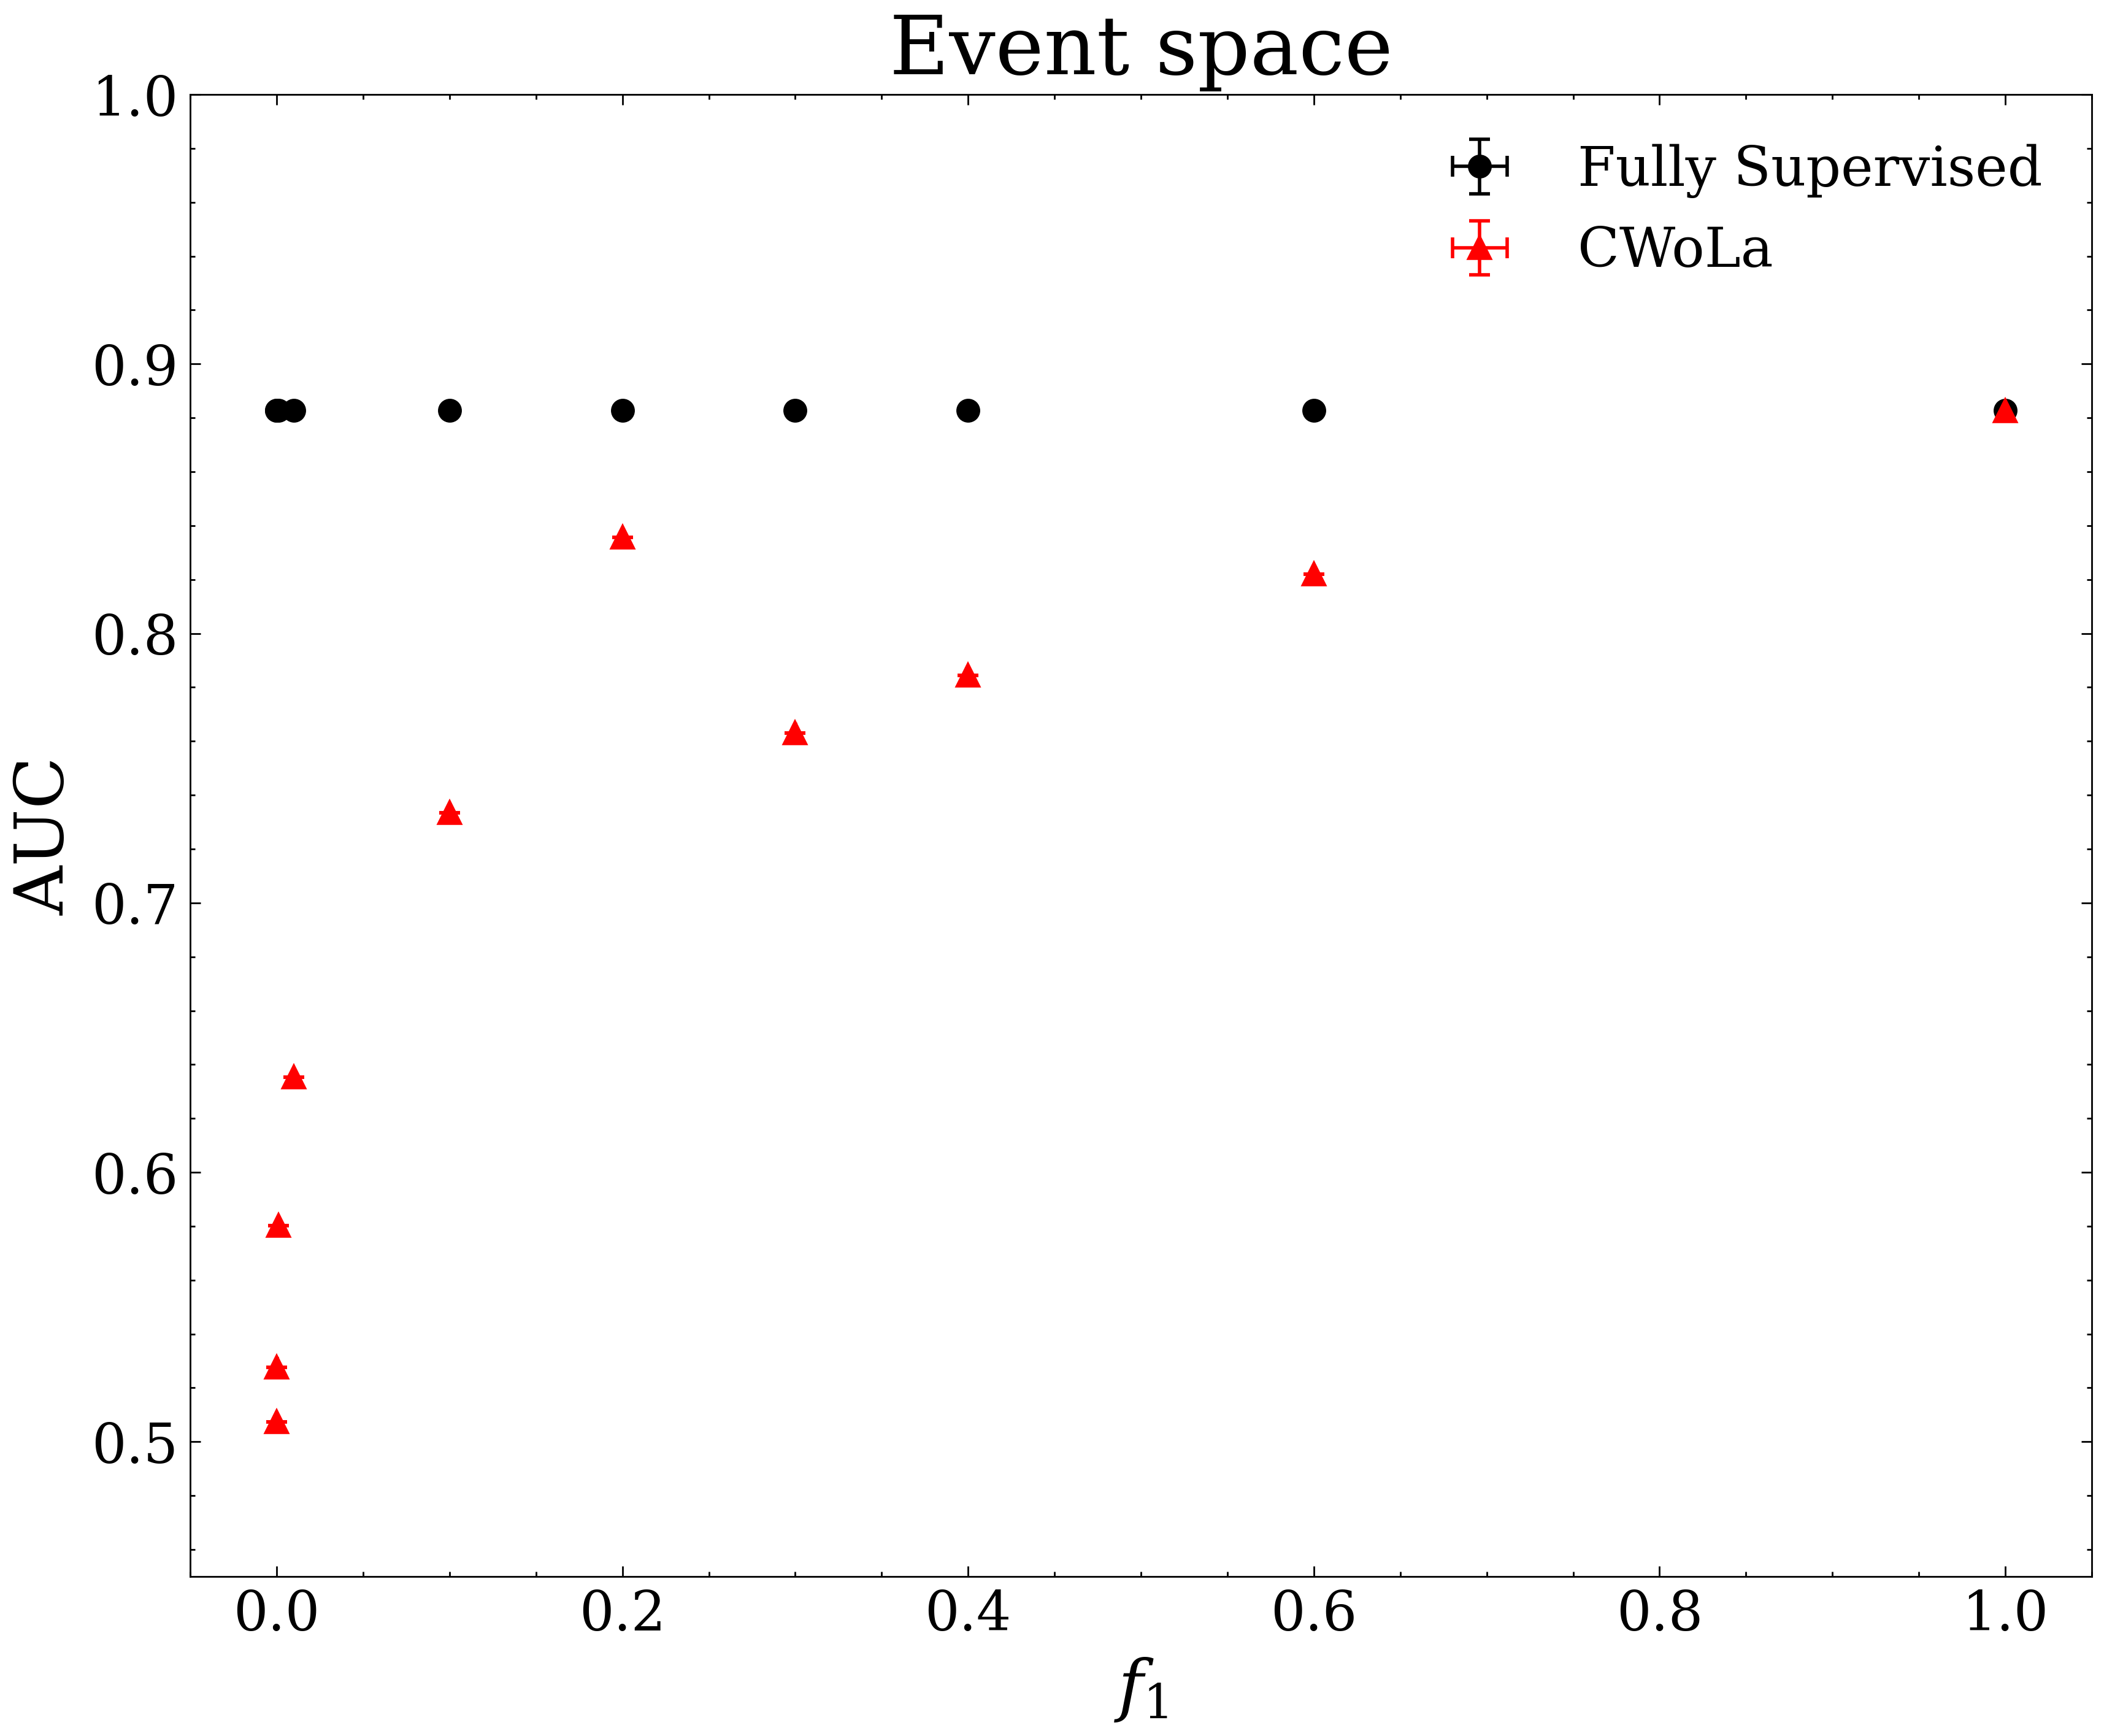

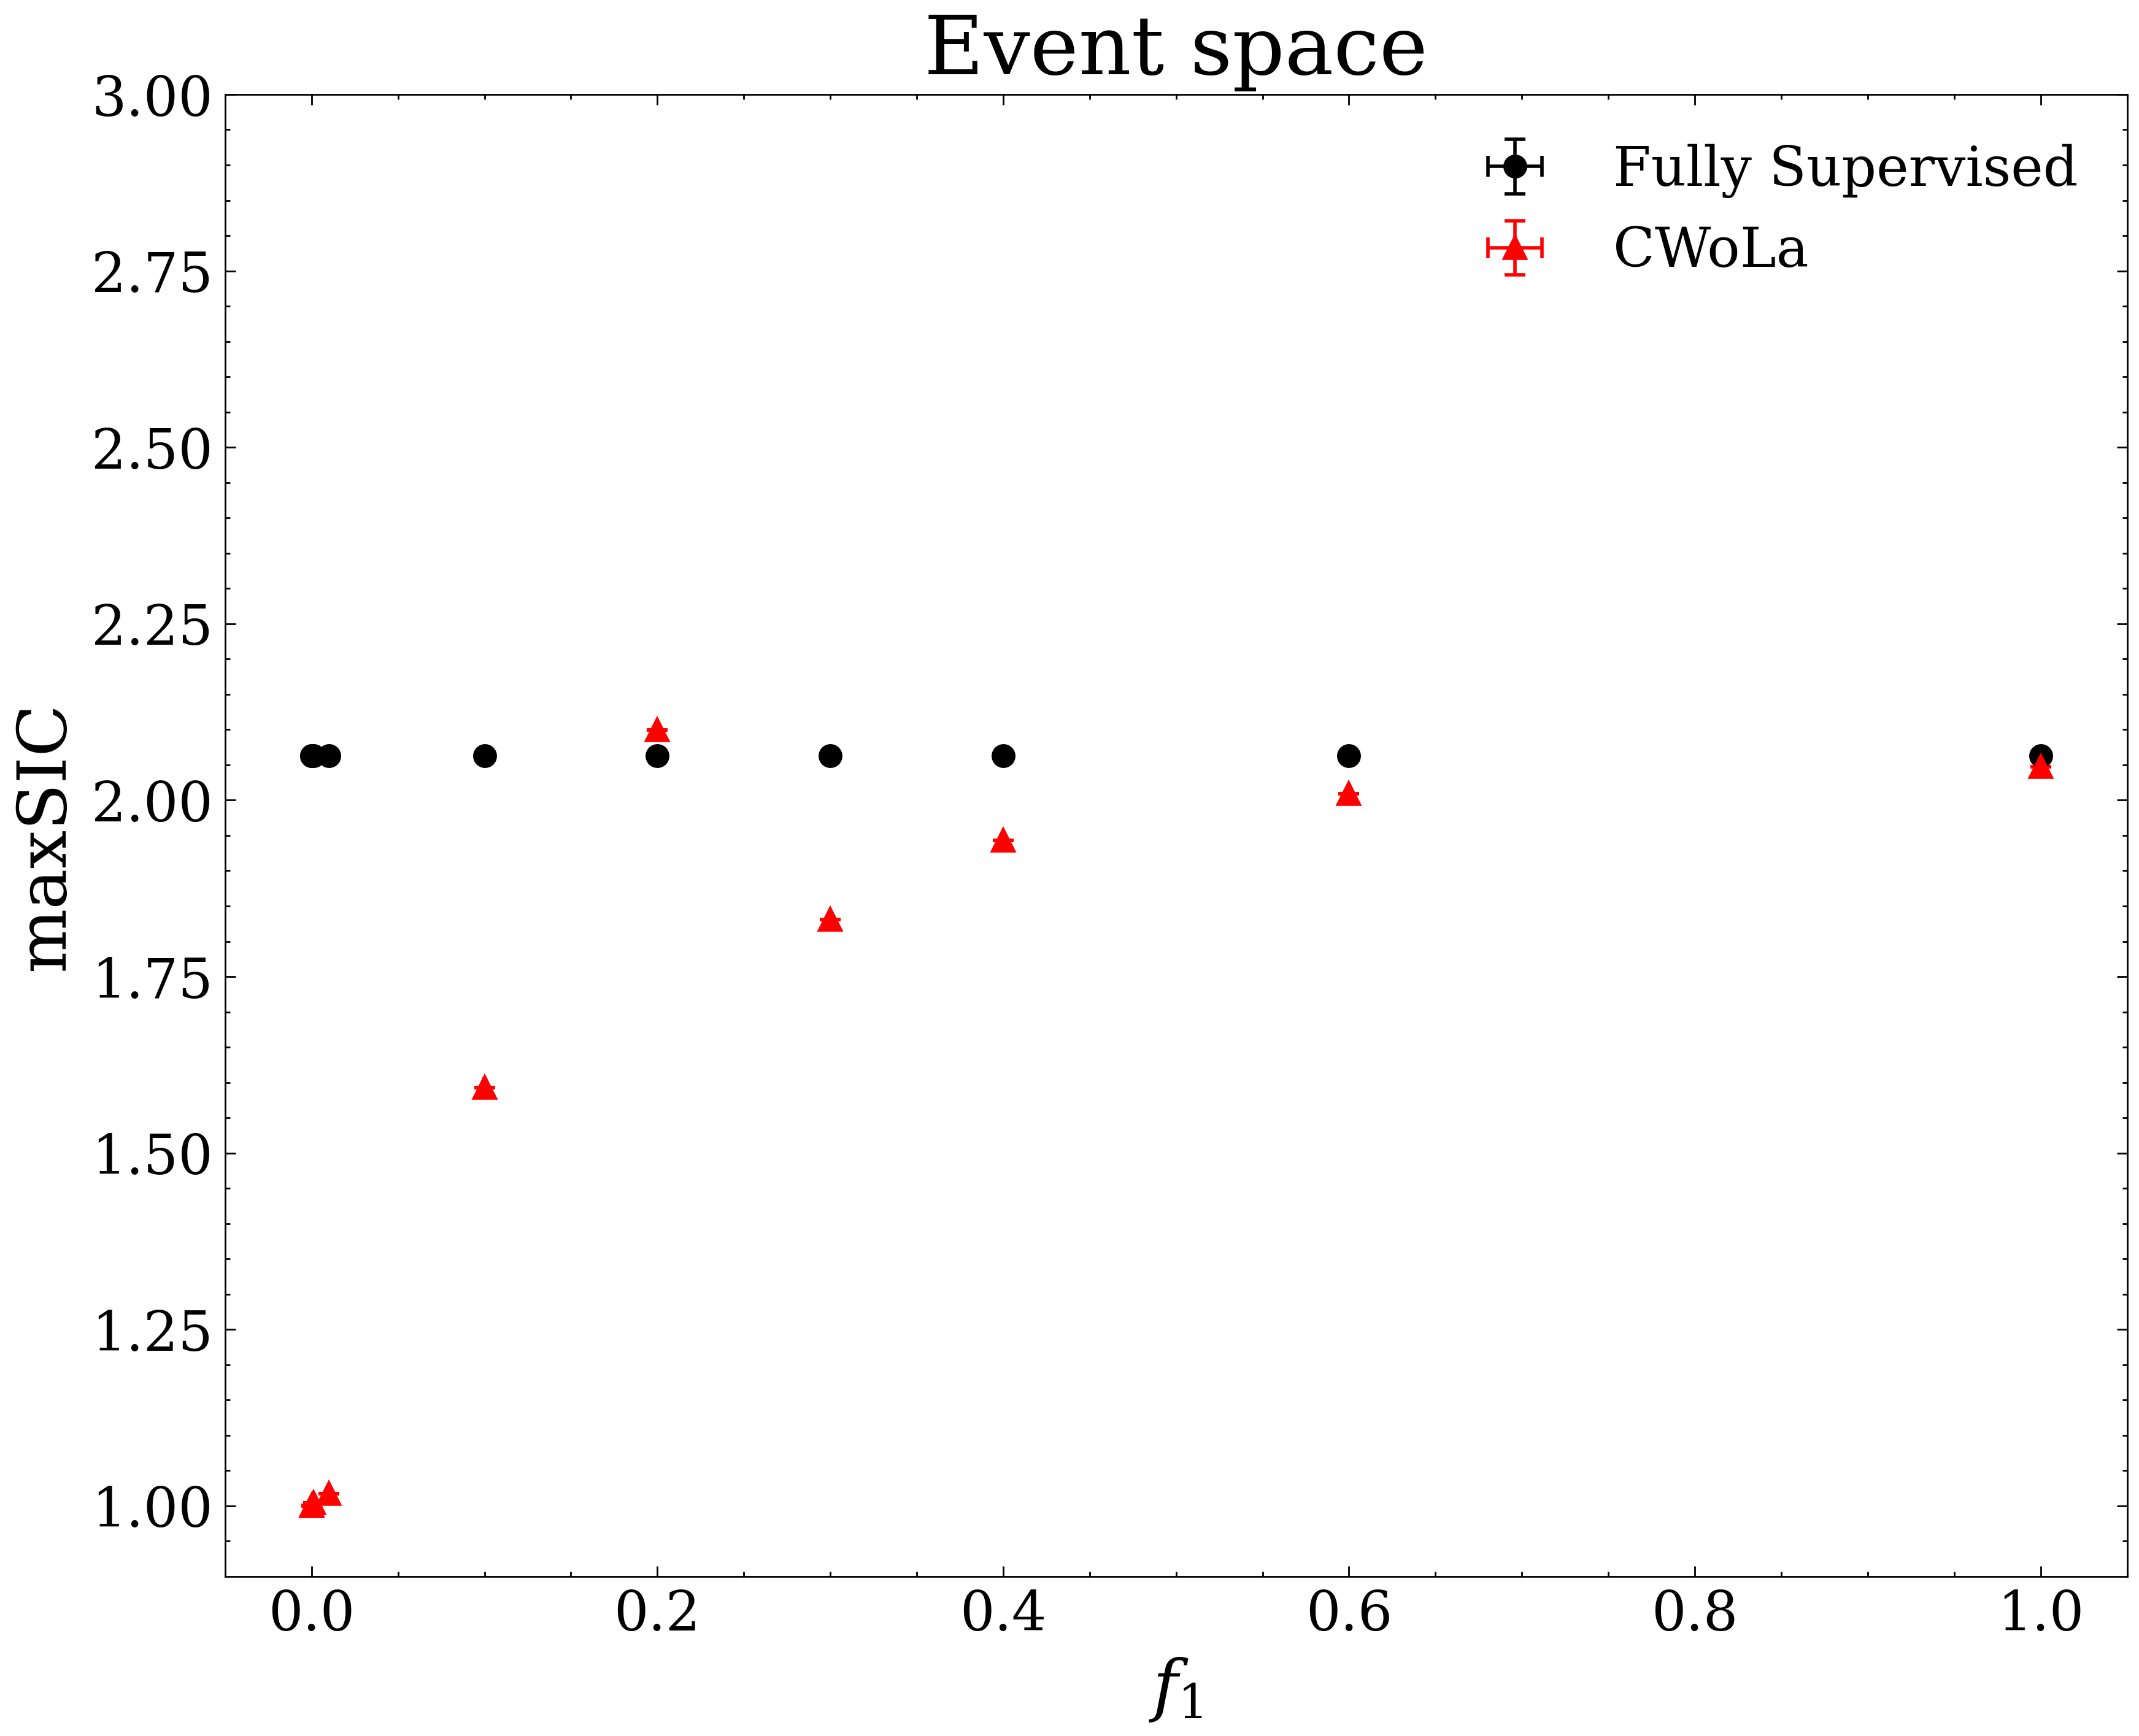

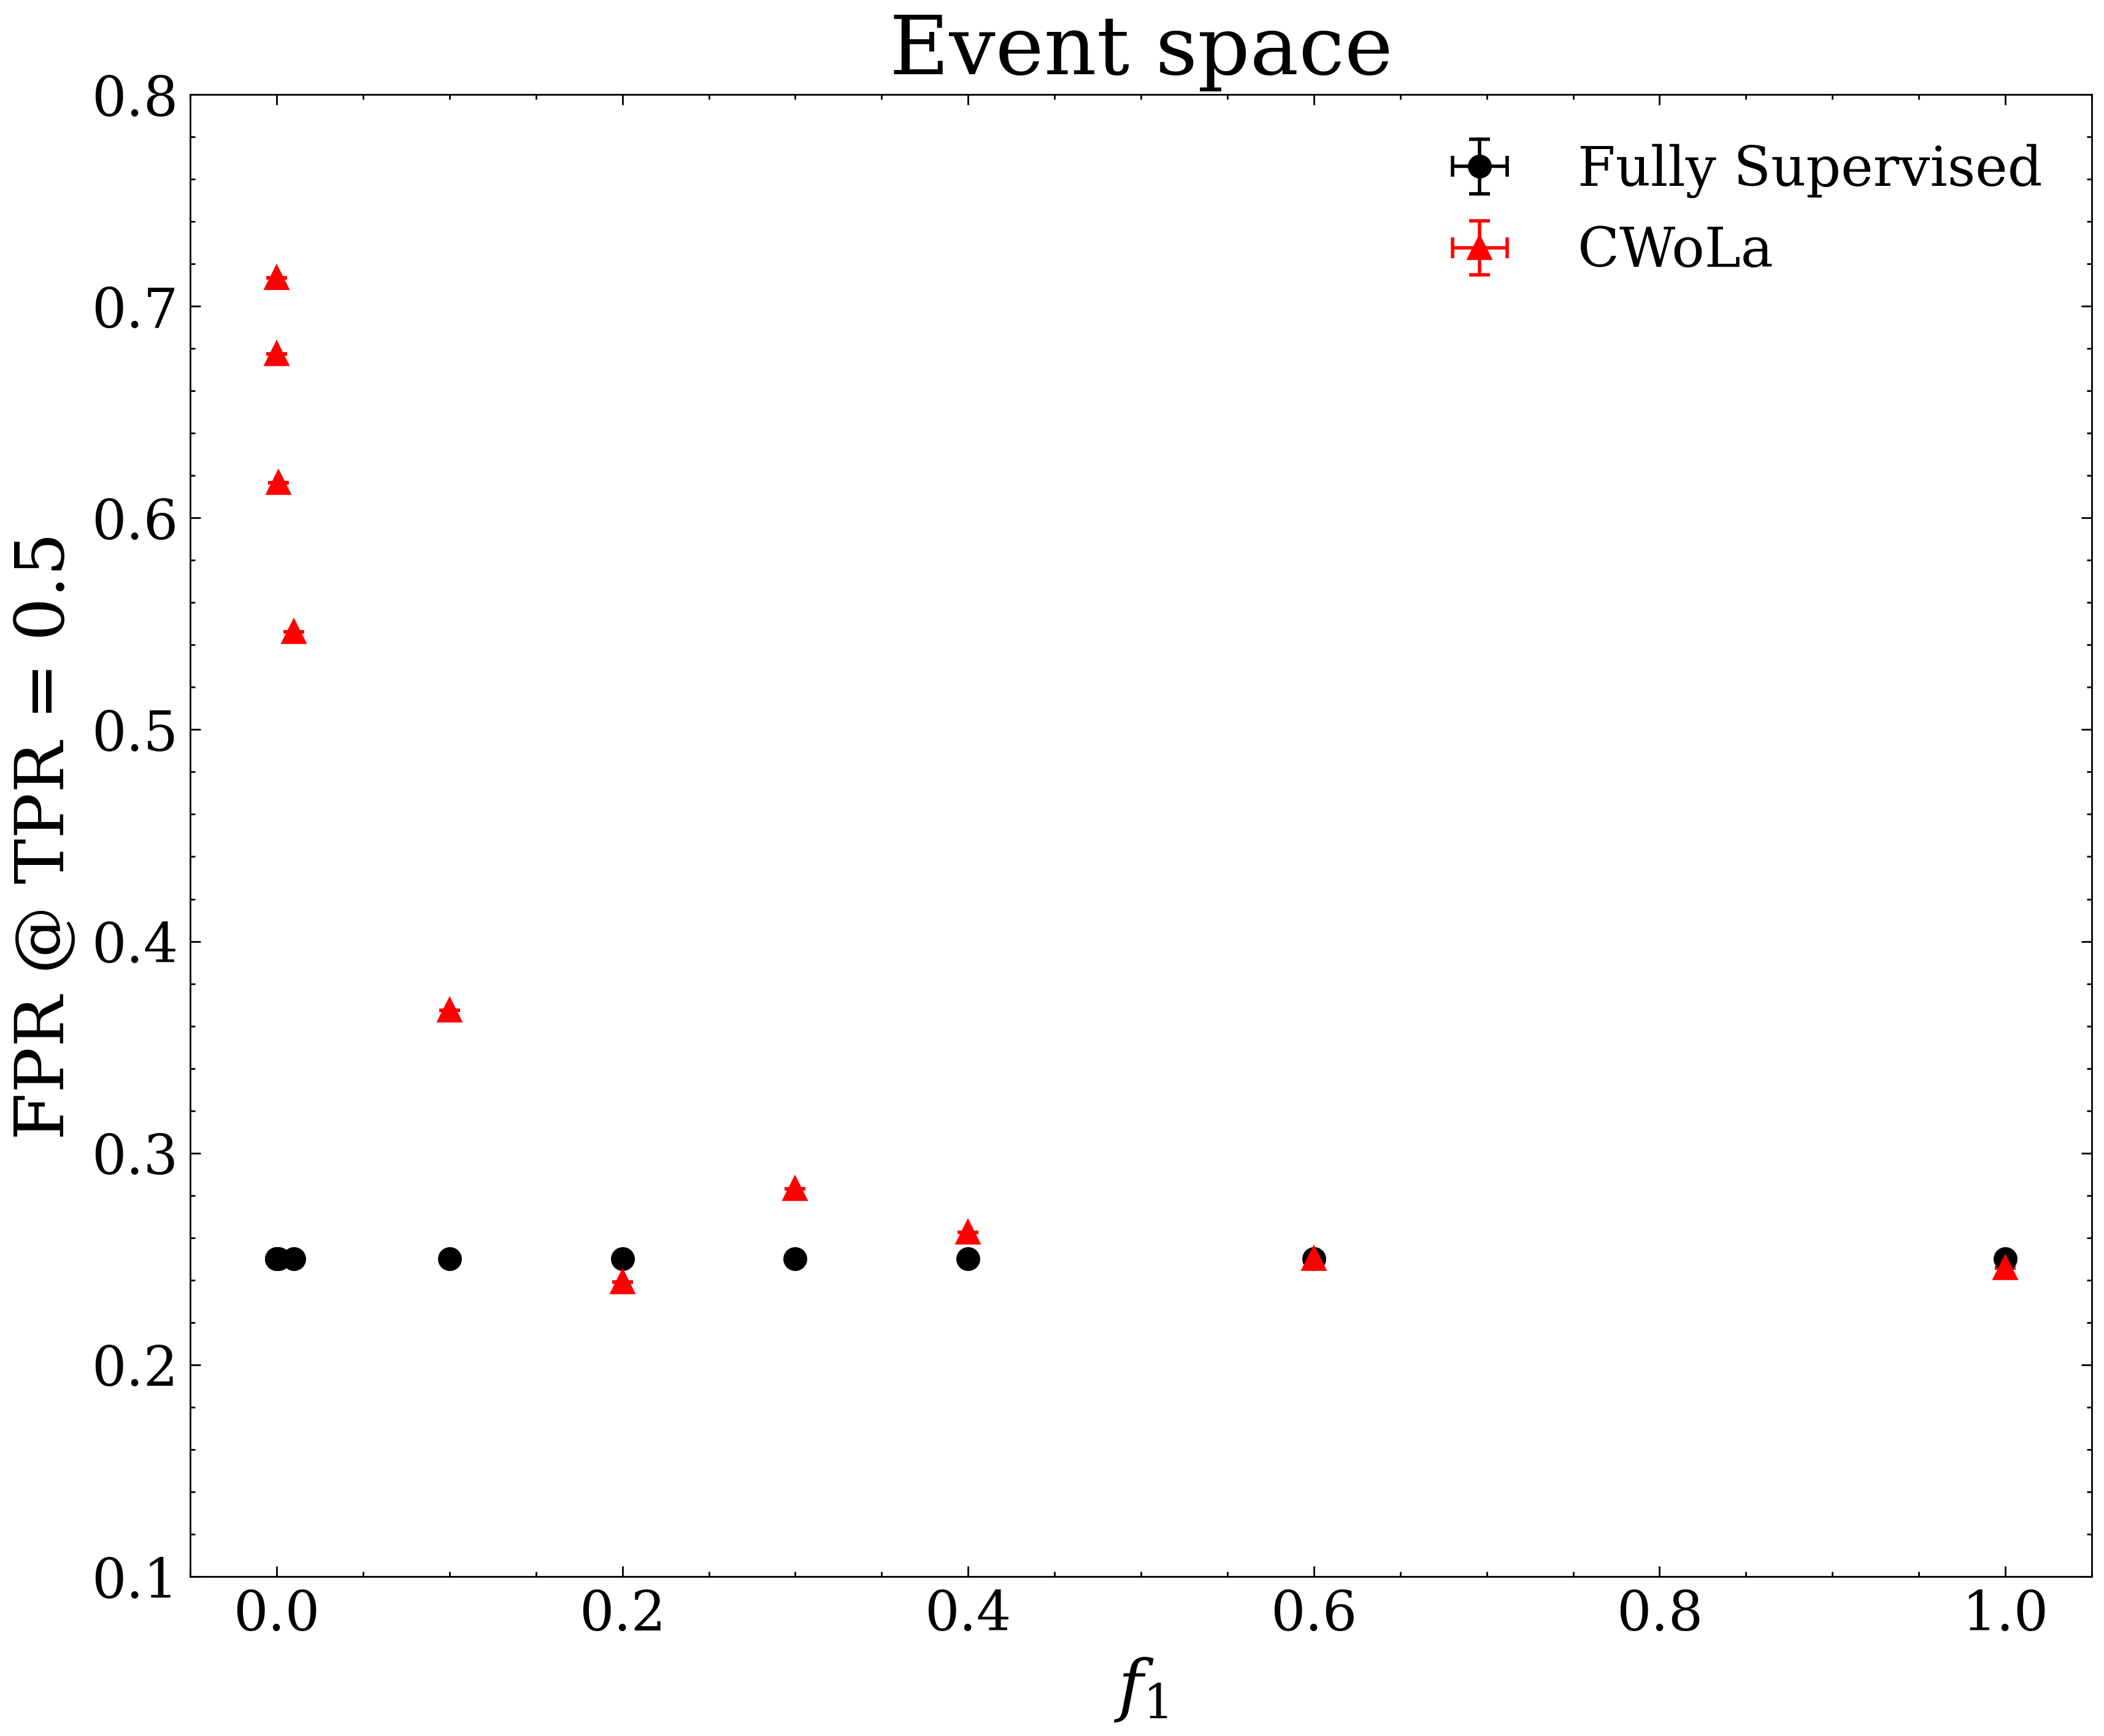

In [29]:
plt.style.use("science.mplstyle")

pdf_name = "JetCLR_CWoLa_ConstRep.pdf"
pp = PdfPages(pdf_name)

capsize = 3
xerr = .5*(f1_vals[1] - f1_vals[0])
    

fig = plt.figure(figsize = (10,8))
plt.errorbar(f1_vals, avg_full_sup_results_dict["AUC"][0], yerr = avg_full_sup_results_dict["AUC"][1], label = "Fully Supervised", color = "k", capsize = capsize, fmt = "o", xerr = xerr)
plt.errorbar(f1_vals, avg_cwola_results_dict["AUC"][0], yerr = avg_cwola_results_dict["AUC"][1], label = "CWoLa", color = "r", capsize = capsize, fmt = "^", xerr = xerr)
plt.legend()
plt.xlabel("$f_1$")
plt.ylabel("AUC")
plt.ylim(0.45, 1)
plt.title("Event space")
plt.show()
pp.savefig(fig)

fig = plt.figure(figsize = (10,8))
plt.errorbar(f1_vals, avg_full_sup_results_dict["maxsic"][0], yerr = avg_full_sup_results_dict["maxsic"][1], label = "Fully Supervised", color = "k", capsize = capsize, fmt = "o", xerr = xerr)
plt.errorbar(f1_vals, avg_cwola_results_dict["maxsic"][0], yerr = avg_cwola_results_dict["maxsic"][1], label = "CWoLa", color = "r", capsize = capsize, fmt = "^", xerr = xerr)
plt.legend()
plt.xlabel("$f_1$")
plt.ylabel("maxSIC")
plt.ylim(0.9, 3)
plt.title("Event space")
plt.show()
pp.savefig(fig)

fig = plt.figure(figsize = (10,8))
plt.errorbar(f1_vals, avg_full_sup_results_dict["FPRatTPR"][0], yerr = avg_full_sup_results_dict["FPRatTPR"][1], label = "Fully Supervised", color = "k", capsize = capsize, fmt = "o", xerr = xerr)
plt.errorbar(f1_vals, avg_cwola_results_dict["FPRatTPR"][0], yerr = avg_cwola_results_dict["FPRatTPR"][1], label = "CWoLa", color = "r", capsize = capsize, fmt = "^", xerr = xerr)
plt.legend()
plt.xlabel("$f_1$")
plt.ylabel("FPR @ TPR = 0.5")
plt.ylim(0.1, 0.8)
plt.title("Event space")
plt.show()
pp.savefig(fig)


    
pp.savefig(fig)
pp.close()


